In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
knightking007_aadhar_path = kagglehub.dataset_download('knightking007/aadhar')

print('Data source import complete.')


100%|██████████| 2.21M/2.21M [00:00<00:00, 83.1MB/s]

Extracting files...


Data source import complete.


In [3]:
!pip install pyspark

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("AadharAnalysis").getOrCreate()

##  Load and Inspect

In [12]:
# use schema instead of inferSchema for safety
df = spark.read.csv(path = knightking007_aadhar_path, sep = ',', header = True, quote= '"', inferSchema= True )

In [13]:
df.show()

+--------------------+--------------------+-------------+----------+------------+--------+------+---+-----------------+------------------+-------------------------+---------------------------------+
|           Registrar|    Enrolment Agency|        State|  District|Sub District|Pin Code|Gender|Age|Aadhaar generated|Enrolment Rejected|Residents providing email|Residents providing mobile number|
+--------------------+--------------------+-------------+----------+------------+--------+------+---+-----------------+------------------+-------------------------+---------------------------------+
|      Allahabad Bank|A-Onerealtors Pvt...|Uttar Pradesh| Allahabad|        Meja|  212303|     F|  7|                1|                 0|                        0|                                1|
|      Allahabad Bank|Asha Security Gua...|Uttar Pradesh| Sonbhadra| Robertsganj|  231213|     M|  8|                1|                 0|                        0|                                0|
|    

In [14]:
df.printSchema()

root
 |-- Registrar: string (nullable = true)
 |-- Enrolment Agency: string (nullable = true)
 |-- State: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Sub District: string (nullable = true)
 |-- Pin Code: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Aadhaar generated: integer (nullable = true)
 |-- Enrolment Rejected: integer (nullable = true)
 |-- Residents providing email: integer (nullable = true)
 |-- Residents providing mobile number: integer (nullable = true)



## Data Cleaning & Transformation

In [27]:
from pyspark.sql.functions import col

# Drop duplicates
df = df.dropDuplicates()

# Handle missing values
df = df.na.fill({'Aadhaar generated': 0, 'Enrolment Rejected': 0})

# Convert data types if needed
df = df.withColumn("Pin Code", col("Pin Code").cast("string"))

# Create Age Group column
df = df.withColumn("Age Group", when(col("Age") < 18, "0-17")
                               .when((col("Age") >= 18) & (col("Age") < 30), "18-29")
                               .when((col("Age") >= 30) & (col("Age") < 45), "30-44")
                               .when((col("Age") >= 45) & (col("Age") < 60), "45-59")
                               .otherwise("60+"))

# Filter invalid age values (assuming valid age range is 0-150)
df = df.filter((col("Age") >= 0) & (col("Age") <= 150))

df.show(5)

+--------------------+--------------------+---------+----------------+------------+--------+------+---+-----------------+------------------+-------------------------+---------------------------------+---------+
|           Registrar|    Enrolment Agency|    State|        District|Sub District|Pin Code|Gender|Age|Aadhaar generated|Enrolment Rejected|Residents providing email|Residents providing mobile number|Age Group|
+--------------------+--------------------+---------+----------------+------------+--------+------+---+-----------------+------------------+-------------------------+---------------------------------+---------+
|Atalji Janasnehi ...|Atalji Janasnehi ...|Karnataka|     Chitradurga|  Challakere|  577502|     F| 29|                1|                 0|                        0|                                1|    18-29|
|Atalji Janasnehi ...|Atalji Janasnehi ...|Karnataka|Dakshina Kannada|     Bantwal|  574219|     F| 24|                0|                 1|                

### ETL

In [28]:
aadhaar_rate_df = df.groupBy("State").agg(
    (sum("Aadhaar generated") / (sum("Aadhaar generated") + sum("Enrolment Rejected")) * 100)
    .alias("Aadhaar Generation Rate")
)

In [29]:
df.write.mode("overwrite").parquet("processed_aadhaar_data.parquet")

aadhaar_rate_df.write.mode("overwrite").parquet("aadhaar_generation_rate.parquet")



ETL Process Completed: Data Saved Successfully ✅


## Exploratory Data Analysis (EDA)

In [16]:
from pyspark.sql.functions import sum

statewise_aadhaar = df.groupBy("State").agg(sum("Aadhaar generated").alias("Total Aadhaar"))
statewise_aadhaar.show()


+--------------------+-------------+
|               State|Total Aadhaar|
+--------------------+-------------+
|            Nagaland|          545|
|           Karnataka|        19764|
|              Odisha|        18182|
|              Kerala|        15143|
|          Tamil Nadu|        32485|
|        Chhattisgarh|         6604|
|      Andhra Pradesh|         5798|
|         Lakshadweep|            4|
|      Madhya Pradesh|        53276|
|              Punjab|         6506|
|             Manipur|         1323|
|                 Goa|         1167|
|             Mizoram|         6279|
|Dadra and Nagar H...|          140|
|    Himachal Pradesh|         1547|
|          Puducherry|           83|
|             Haryana|         6804|
|   Jammu and Kashmir|         1234|
|           Jharkhand|         9868|
|   Arunachal Pradesh|          913|
+--------------------+-------------+
only showing top 20 rows



In [17]:
from pyspark.sql.functions import count

gender_distribution = df.groupBy("Gender").agg(count("*").alias("Count"))
gender_distribution.show()


+------+------+
|Gender| Count|
+------+------+
|     F|148013|
|     T|     7|
|     M|292798|
+------+------+



In [18]:
df.groupBy("District").agg(sum("Aadhaar generated").alias("Total Aadhaar")) \
  .orderBy(col("Total Aadhaar").desc()).show(5)


+-----------------+-------------+
|         District|Total Aadhaar|
+-----------------+-------------+
|South 24 Parganas|        16207|
|       Barddhaman|        15821|
|        Bhagalpur|        14479|
|North 24 Parganas|        11273|
|             Gaya|        10755|
+-----------------+-------------+
only showing top 5 rows



## Data Visualization

<ipython-input-21-9deb765f16af>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=pandas_df["State"], x=pandas_df["Total Aadhaar"], palette="viridis")


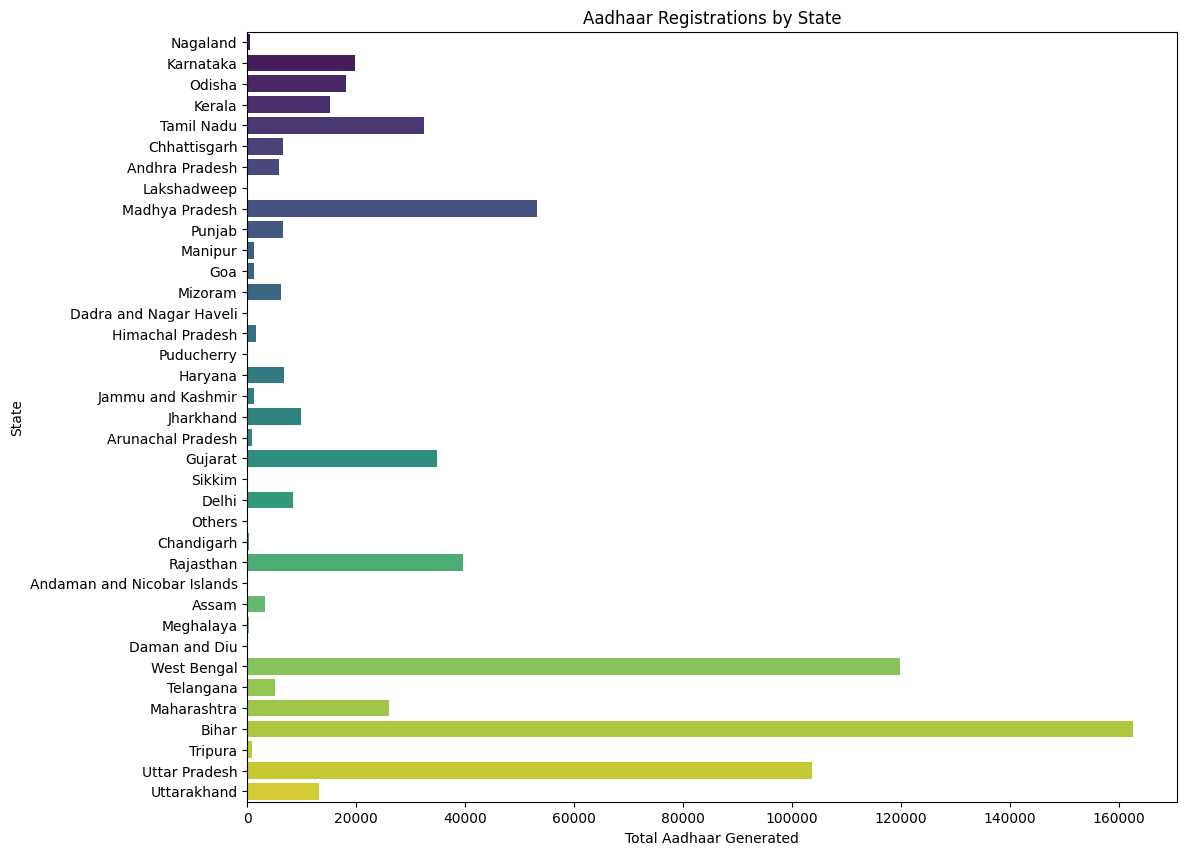

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pandas_df = statewise_aadhaar.toPandas()

plt.figure(figsize=(12,10))
sns.barplot(y=pandas_df["State"], x=pandas_df["Total Aadhaar"], palette="viridis")
plt.xlabel("Total Aadhaar Generated")
plt.ylabel("State")
plt.title("Aadhaar Registrations by State")
plt.show()


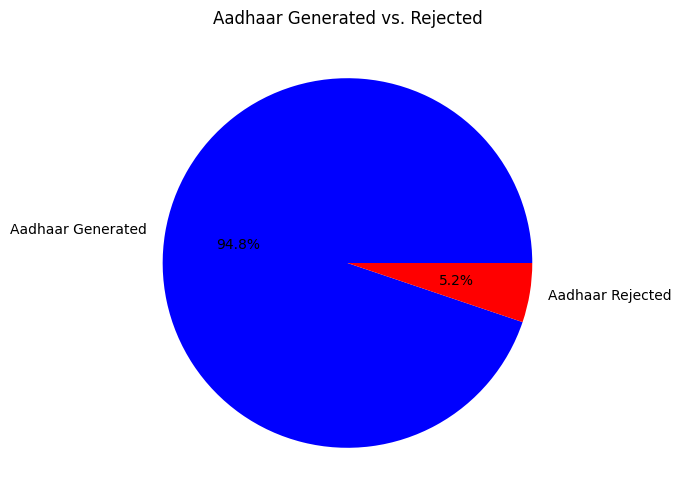

In [24]:
approval_vs_rejection_df = df.agg(
    sum("Aadhaar generated").alias("Aadhaar Generated"),
    sum("Enrolment Rejected").alias("Aadhaar Rejected")
)

approval_vs_rejection_pd = approval_vs_rejection_df.toPandas().T.reset_index()
approval_vs_rejection_pd.columns = ["Category", "Count"]

plt.figure(figsize=(6,6))
plt.pie(approval_vs_rejection_pd["Count"], labels=approval_vs_rejection_pd["Category"], autopct="%1.1f%%", colors=["blue", "red"])
plt.title("Aadhaar Generated vs. Rejected")
plt.show()


<ipython-input-25-63ae170e8300>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_group_pd["Age Group"], y=age_group_pd["Total Aadhaar"], palette="coolwarm")


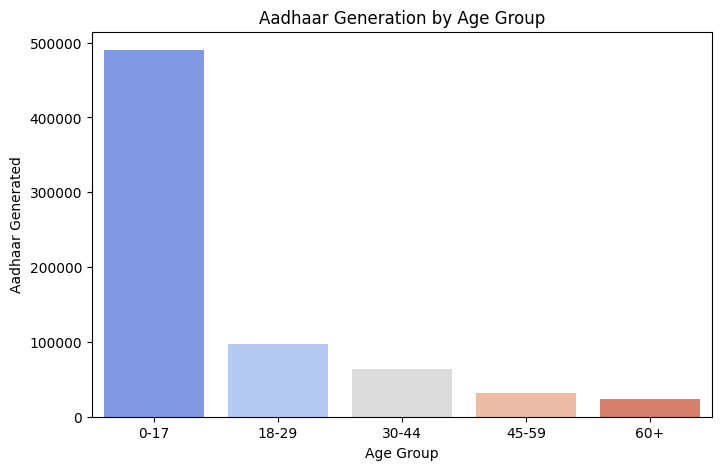

In [25]:
from pyspark.sql.functions import when

age_group_df = df.groupBy("Age Group").agg(sum("Aadhaar generated").alias("Total Aadhaar"))

age_group_pd = age_group_df.toPandas().sort_values("Age Group")

plt.figure(figsize=(8,5))
sns.barplot(x=age_group_pd["Age Group"], y=age_group_pd["Total Aadhaar"], palette="coolwarm")
plt.xlabel("Age Group")
plt.ylabel("Aadhaar Generated")
plt.title("Aadhaar Generation by Age Group")
plt.show()
